In [82]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # plotting graphs
import pickle
import sklearn
%matplotlib inline

In [83]:
trainData=pd.read_csv("bbcNews/BBC News Train.csv")
testData=pd.read_csv("bbcNews/BBC News Test.csv")
sampleData=pd.read_csv("bbcNews/BBC News Sample Solution.csv")
trainData.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [84]:
trainData["Category"].unique()

array(['business', 'tech', 'politics', 'sport', 'entertainment'],
      dtype=object)

In [85]:
testData.head()

,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


In [86]:
sampleData.head()

,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,business
3,459,entertainment
4,1020,politics


In [87]:
# Associate Category names with numerical index and save it in new column category_id
trainData['category_id'] = trainData['Category'].factorize()[0]

#View first 10 entries of category_id, as a sanity check
trainData['category_id'][0:10]

0    0
1    0
2    0
3    1
4    0
5    2
6    3
7    4
8    0
9    4
Name: category_id, dtype: int64

In [88]:
# Create a new pandas dataframe "category_id_df", which only has unique Categories, also sorting this list in order of category_id values
category_id_df = trainData[['Category', 'category_id']].drop_duplicates().sort_values('category_id')

In [89]:
category_id_df

,Category,category_id
0,business,0
3,tech,1
5,politics,2
6,sport,3
7,entertainment,4


In [90]:
# Create a dictionary ( python datastructure - like a lookup table) that 
# can easily convert category names into category_ids and vice-versa
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Category']].values)

In [91]:
id_to_category

import json
with open('id_to_category.json', 'w') as fp:
    json.dump(id_to_category, fp)

In [92]:
# Pick 5 random samples from the dataframe
sampleData.sample(5, random_state=0)

,ArticleId,Category
196,541,tech
187,1892,business
14,297,politics
31,185,tech
390,1416,sport


In [93]:
# Group the dataframe by categories and count items ( number of news articles) in each category
trainData.groupby('Category').category_id.count()

Category
business         336
entertainment    273
politics         274
sport            346
tech             261
Name: category_id, dtype: int64

In [94]:
labels=['business','entertainment','politics','sport','tech']
values=trainData.groupby('Category').category_id.count()

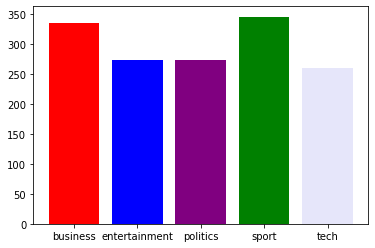

In [95]:
plt.bar(labels, values, color=['red', 'blue', 'purple', 'green', 'lavender'])
plt.show()

In [96]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(trainData.Text).toarray() # Remaps the words in the 1490 articles in the text column of 
                                                  # data frame into features (superset of words) with an importance assigned 
                                                  # based on each words frequency in the document and across documents

labels = trainData.category_id                           # represents the category of each of the 1490 articles

In [97]:
with open('vectorizer.pk', 'wb') as fin:
     pickle.dump(tfidf, fin)

In [98]:
features.shape

(1490, 9927)

In [99]:
# Remember the dictionary created to map category names to a number ? 
category_to_id.items()

dict_items([('business', 0), ('tech', 1), ('politics', 2), ('sport', 3), ('entertainment', 4)])

In [100]:
# The sorted function Converts dictionary items into a (sorted) list. 
# In subsequent steps - We will use this list to iterate over the categories
sorted(category_to_id.items())

[('business', 0),
 ('entertainment', 4),
 ('politics', 2),
 ('sport', 3),
 ('tech', 1)]

In [101]:
# Use chi-square analysis to find corelation between features (importantce of words) and labels(news category) 
from sklearn.feature_selection import chi2

N = 3  # We are going to look for top 3 categories

#For each category, find words that are highly corelated to it
for Category, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)                   # Do chi2 analyses of all items in this category
    indices = np.argsort(features_chi2[0])                                  # Sorts the indices of features_chi2[0] - the chi-squared stats of each feature
    feature_names = np.array(tfidf.get_feature_names())[indices]            # Converts indices to feature names ( in increasing order of chi-squared stat values)
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]         # List of single word features ( in increasing order of chi-squared stat values)
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]          # List for two-word features ( in increasing order of chi-squared stat values)
    print("# '{}':".format(Category))
    print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:]))) # Print 3 unigrams with highest Chi squared stat
    print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:]))) # Print 3 bigrams with highest Chi squared stat

# 'business':
  . Most correlated unigrams:
       . growth
       . bank
       . shares
  . Most correlated bigrams:
       . stock market
       . economic growth
       . analysts said
# 'entertainment':
  . Most correlated unigrams:
       . singer
       . actor
       . film
  . Most correlated bigrams:
       . won best
       . los angeles
       . box office
# 'politics':
  . Most correlated unigrams:
       . blair
       . election
       . labour
  . Most correlated bigrams:
       . prime minister
       . tony blair
       . mr blair
# 'sport':
  . Most correlated unigrams:
       . match
       . coach
       . cup
  . Most correlated bigrams:
       . grand slam
       . champions league
       . australian open
# 'tech':
  . Most correlated unigrams:
       . technology
       . software
       . users
  . Most correlated bigrams:
       . anti virus
       . mobile phones
       . mobile phone


In [102]:
features_chi2

(array([0.13345481, 0.01563765, 0.00108776, ..., 0.00812363, 0.15434356,
        0.120306  ]),
 array([0.71487652, 0.9004835 , 0.97368962, ..., 0.92818297, 0.69441858,
        0.72870284]))

In [44]:
from sklearn.manifold import TSNE

# Sampling a subset of our dataset because t-SNE is computationally expensive
SAMPLE_SIZE = int(len(features) * 0.3)
np.random.seed(0)
indices = np.random.choice(range(len(features)), size=SAMPLE_SIZE, replace=False)          # Randomly select 30 % of samples
projected_features = TSNE(n_components=2, random_state=0).fit_transform(features[indices]) # Array of all projected features of 30% of Randomly chosen samples 

In [46]:
type(projected_features)

numpy.ndarray

In [48]:
my_id = 0 # Select a category_id
projected_features[(labels[indices] == my_id).values]

array([[-17.409828  , -20.436989  ],
       [ -9.56882   , -11.314312  ],
       [-17.156994  ,  -6.452465  ],
       [-10.862223  , -21.660397  ],
       [-19.501608  ,   4.6090965 ],
       [-11.990335  , -16.382895  ],
       [-27.134926  ,  -2.8496113 ],
       [ -9.668595  , -17.357132  ],
       [  8.465661  ,  -9.051764  ],
       [-19.876314  ,  -9.820042  ],
       [  2.6430216 ,   3.9847393 ],
       [-15.166494  , -10.5767145 ],
       [ 15.052534  , -22.136509  ],
       [-29.180244  , -15.261823  ],
       [-11.231472  , -24.399818  ],
       [-13.417371  , -11.908246  ],
       [ -8.409627  , -11.635613  ],
       [-11.572334  , -18.307085  ],
       [-17.998095  , -14.864076  ],
       [-26.832064  ,  -5.992347  ],
       [ -0.91015923, -20.449903  ],
       [-23.755339  , -14.732829  ],
       [-17.284416  ,  -6.835661  ],
       [-22.186396  , -10.912631  ],
       [-11.207357  , -14.555125  ],
       [-25.065447  , -10.098723  ],
       [-22.816729  , -12.928076  ],
 

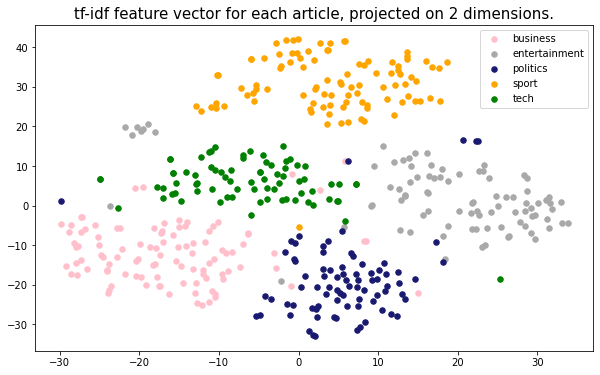

In [50]:
colors = ['pink', 'green', 'midnightblue', 'orange', 'darkgrey']

plt.figure(figsize=(10,6))
# Find points belonging to each category and plot them
for category, category_id in sorted(category_to_id.items()):
    points = projected_features[(labels[indices] == category_id).values]
    plt.scatter(points[:, 0], points[:, 1], s=30, c=colors[category_id], label=category)
plt.title("tf-idf feature vector for each article, projected on 2 dimensions.",fontdict=dict(fontsize=15))

plt.legend()

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

In [54]:
CV = 5  # Cross Validate with 5 different folds of 20% data ( 80-20 split with 5 folds )

#Create a data frame that will store the results for all 5 trials of the 3 different models
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = [] # Initially all entries are empty

In [56]:
#For each Algorithm 
for model in models:
    model_name = model.__class__.__name__
    # create 5 models with different 20% test sets, and store their accuracies
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    # Append all 5 accuracies into the entries list ( after all 3 models are run, there will be 3x5 = 15 entries)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

In [58]:
# Store the entries into the results dataframe and name its columns    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

<AxesSubplot:xlabel='model_name', ylabel='accuracy'>

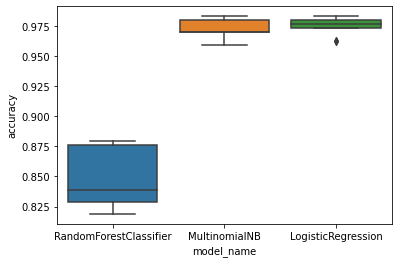

In [60]:
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)

In [62]:
# Mean accuracy of each algorithm
cv_df.groupby('model_name').accuracy.mean()

model_name
LogisticRegression        0.975168
MultinomialNB             0.972483
RandomForestClassifier    0.848322
Name: accuracy, dtype: float64

In [64]:
cv_df

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.838926
1,RandomForestClassifier,1,0.818792
2,RandomForestClassifier,2,0.828859
3,RandomForestClassifier,3,0.875839
4,RandomForestClassifier,4,0.879195
5,MultinomialNB,0,0.969799
6,MultinomialNB,1,0.959732
7,MultinomialNB,2,0.983221
8,MultinomialNB,3,0.979866
9,MultinomialNB,4,0.969799


In [66]:
from sklearn.model_selection import train_test_split

model = LogisticRegression(random_state=0)

#Split Data 
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, trainData.index, test_size=0.33, random_state=0)

#Train Algorithm
model.fit(X_train, y_train)

# Make Predictions
y_pred_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)

Text(0.5, 15.0, 'Predicted')

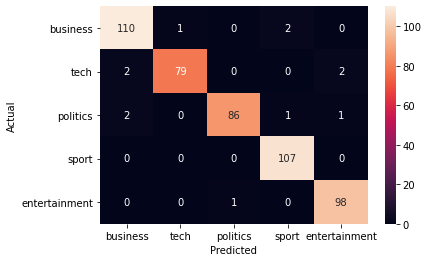

In [68]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [70]:
from IPython.display import display

for predicted in category_id_df.category_id:
    for actual in category_id_df.category_id:
        if predicted != actual and conf_mat[actual, predicted] >= 2:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
            display(trainData.loc[indices_test[(y_test == actual) & (y_pred == predicted)]]['Text'])
            print('')

'tech' predicted as 'business' : 2 examples.


641    us woman sues over cartridges a us woman is su...
549    man auctions ad space on forehead a 20-year-ol...
Name: Text, dtype: object


'politics' predicted as 'business' : 2 examples.


962    hatfield executives go on trial engineering fi...
249    eu fraud clampdown urged eu member states are ...
Name: Text, dtype: object


'business' predicted as 'sport' : 2 examples.


61     arsenal  may seek full share listing  arsenal ...
728    christmas shoppers flock to tills shops all ov...
Name: Text, dtype: object


'tech' predicted as 'entertainment' : 2 examples.


1091    ultimate game  award for doom 3 sci-fi shooter...
1115    ultimate game  award for doom 3 sci-fi shooter...
Name: Text, dtype: object

In [72]:
model.fit(features, labels)

LogisticRegression(random_state=0)

In [74]:
# model.coef_ contains the importance of each feature for each category
model.coef_

array([[ 0.46799432,  0.01813872, -0.0715333 , ..., -0.03318298,
         0.0068823 , -0.02849203],
       [-0.02957523, -0.04366737, -0.01371468, ...,  0.00362675,
        -0.02877942, -0.02070068],
       [ 0.05006025, -0.05159908, -0.04674601, ..., -0.00638322,
        -0.03112648, -0.02362395],
       [-0.61687406, -0.04152046, -0.05352312, ...,  0.08450437,
         0.08574049,  0.09981232],
       [ 0.12839471,  0.11864819,  0.18551711, ..., -0.04856492,
        -0.03271689, -0.02699566]])

In [76]:
from sklearn.feature_selection import chi2

N = 5
for Category, category_id in sorted(category_to_id.items()):
    indices = np.argsort(model.coef_[category_id])   # This time using the model co-eficients / weights
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
    bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
    print("# '{}':".format(Category))
    print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
    print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'business':
  . Top unigrams:
       . firm
       . bank
       . company
       . shares
       . market
  . Top bigrams:
       . chief executive
       . analysts said
       . stock market
       . economic growth
       . oil prices
# 'entertainment':
  . Top unigrams:
       . film
       . music
       . singer
       . star
       . band
  . Top bigrams:
       . box office
       . los angeles
       . film festival
       . new york
       . big brother
# 'politics':
  . Top unigrams:
       . labour
       . mr
       . party
       . election
       . government
  . Top bigrams:
       . mr blair
       . prime minister
       . tony blair
       . general election
       . mr brown
# 'sport':
  . Top unigrams:
       . match
       . win
       . game
       . coach
       . cup
  . Top bigrams:
       . year old
       . australian open
       . champions league
       . world cup
       . grand slam
# 'tech':
  . Top unigrams:
       . users
       . software
       .

In [78]:
texts = ["Hooli stock price soared after a dip in PiedPiper revenue growth.",
         "Captain Tsubasa scores a magnificent goal for the Japanese team.",
         "Merryweather mercenaries are sent on another mission, as government oversight groups call for new sanctions.",
         "Beyoncé releases a new album, tops the charts in all of south-east Asia!",
         "You won't guess what the latest trend in data analysis is!"]
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
    print('"{}"'.format(text))
    print("  - Predicted as: '{}'".format(id_to_category[predicted]))
    print("")

"Hooli stock price soared after a dip in PiedPiper revenue growth."
  - Predicted as: 'business'

"Captain Tsubasa scores a magnificent goal for the Japanese team."
  - Predicted as: 'sport'

"Merryweather mercenaries are sent on another mission, as government oversight groups call for new sanctions."
  - Predicted as: 'business'

"Beyoncé releases a new album, tops the charts in all of south-east Asia!"
  - Predicted as: 'entertainment'

"You won't guess what the latest trend in data analysis is!"
  - Predicted as: 'tech'



In [81]:
pkl_filename = "logistic_regression.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)